# SkinSight Preprocessing & Model Evaluation

In this notebook we will show how the preprocessing of the dataset used to train the SkinSight model was done and how the model was evaluated. The used dataset can be downloaded from [here](https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset). This dataset contains 27,153 dermatoscopic images of skin lesions. The original datastet contains 10 classes, but we only are going to use 3 classes: Atopic Dermatitis, Eczema and Melanoma. The reduced dataset can be downloaded from [here](https://nubeusc-my.sharepoint.com/:f:/g/personal/eliseo_pita_rai_usc_es/EtOuVOWFrtJNr2tE7mrjTiwBPLDMcMdEqCAUjqjA5NsG0w?e=eNKcp6).

The class distribution of the reduced dataset is the following:

- Eczema: 1,677 images
- Melanoma: 3,140 images
- Atopic Dermatitis: 1,257 images


In [10]:
import tensorflow as tf

# Check if we have gpu access
gpu_list = tf.config.experimental.list_physical_devices("GPU")
if len(gpu_list) == 0:
    print("No GPU available, using CPU instead")
else:
    for gpu in gpu_list:
        print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


## Data preprocessing

Fisrt we have to implement a class to laod the dataset from the disk and preprocess it. The images of this dataset have different sizes, so we have to resize them to a fixed size. We are going add padding to ensure the images have a square shape, and then resize them to 256x256 pixels.



In [11]:
import os
from PIL import Image


def print_original_image_sizes(data_dir):
    """Prints the unique image sizes in the dataset."""
    image_sizes = set()

    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(("png", "jpg", "jpeg")):
                    image_path = os.path.join(class_path, image_name)

                    # Open image and get its size
                    with Image.open(image_path) as img:
                        width, height = img.size
                        image_sizes.add((width, height))

    print(f"Different image sizes: {len(image_sizes)}")
    sorted_sizes = sorted(image_sizes)
    print("Minimum sizes: ", sorted_sizes[0], sorted_sizes[1])
    print("Maximum sizes: ", sorted_sizes[-2], sorted_sizes[-1])


print_original_image_sizes("data/raw_data/")

Different image sizes: 158
Minimum sizes:  (294, 222) (418, 484)
Maximum sizes:  (720, 712) (720, 1080)


In [46]:
from dataloader import ImageDataLoader

data_dir = "data/raw_data/"
batch_size = 32

data_loader = ImageDataLoader(data_dir, batch_size=batch_size, seed=42)
train_ds, val_ds, test_ds = data_loader.get_datasets()

Num classes: 3. Found classes: ['atopic_dermatitis', 'eczema', 'melanoma']
Num images per class: [1257, 1677, 3140]


In [ ]:
import os
from tensorflow import keras


def generate_ann(
    input_shape=(256, 256, 3),
    filters=[32, 64, 128, 256],
    dense_units=[256, 128],
    output_units=3,
    dropout_rate=0.2,
):
    """
    Generates a Convolutional Neural Network (CNN) model for CIFAR-10.

    Args:
    - filters (list): A list of integers specifying the number of filters in each convolutional layer.
    - dense_units (list): A list of integers specifying the number of units in each fully connected layer.
    - dropout_rate (float): The dropout rate for the fully connected layers.

    Returns:
    - model (tf.keras.Model): The compiled CNN model.
    """

    model = tf.keras.Sequential()

    for i, filter in enumerate(filters):
        if i == 0:
            model.add(
                tf.keras.layers.Conv2D(filter, (3, 3), activation="relu", padding="same", input_shape=input_shape)
            )
        else:
            model.add(tf.keras.layers.Conv2D(filter, (3, 3), activation="relu", padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())

    for units in dense_units:
        model.add(tf.keras.layers.Dense(units, activation="relu"))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(output_units, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="avg_accuracy"), "accuracy"],
    )

    return model


model = generate_ann()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
dir_save_models = "models"
os.makedirs(dir_save_models, exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(dir_save_models + "/best_model.keras", save_best_only=True)

/home/anton.gomez.lopez/miniconda3/envs/skinsight-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/30
  2/133 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.4141 - avg_accuracy: 0.4141 - loss: 2.7634 

2025-03-23 18:45:27.181594: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7831 - avg_accuracy: 0.7831 - loss: 4.2812

2025-03-23 18:45:40.405080: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.7832 - avg_accuracy: 0.7832 - loss: 4.2736 - val_accuracy: 0.5664 - val_avg_accuracy: 0.5664 - val_loss: 11.8075
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8108 - avg_accuracy: 0.8108 - loss: 1.1158 - val_accuracy: 0.5104 - val_avg_accuracy: 0.5104 - val_loss: 7.0281
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.8155 - avg_accuracy: 0.8155 - loss: 0.5967 - val_accuracy: 0.7629 - val_avg_accuracy: 0.7629 - val_loss: 0.6066
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.8195 - avg_accuracy: 0.8195 - loss: 0.4463 - val_accuracy: 0.8101 - val_avg_accuracy: 0.8101 - val_loss: 1.5033
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.8365 - avg_accuracy: 0.8365 - loss: 0.4933 - val_accuracy: 0.8255 - val_avg_accuracy: 0.8255 - val_loss: 0.8945
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8203 - avg_accuracy: 0.8203 - loss: 

In [44]:
import pickle

with open("models/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [45]:
test_loss, test_avg_acc, test_acc = model.evaluate(test_ds)
print(f"Test average accuracy: {test_avg_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8823 - avg_accuracy: 0.8823 - loss: 0.2787
Test average accuracy: 0.8860
Test accuracy: 0.8860


## Evaluate model



In [3]:
import tensorflow as tf

# Check if we have gpu access
gpu_list = tf.config.experimental.list_physical_devices("GPU")
if len(gpu_list) == 0:
    print("No GPU available, using CPU instead")
else:
    for gpu in gpu_list:
        print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [4]:
from dataloader import ImageDataLoader

data_dir = "data/raw_data/"
batch_size = 32

data_loader = ImageDataLoader(data_dir, batch_size=batch_size, seed=42)
train_ds, val_ds, test_ds = data_loader.get_datasets()

Num classes: 3. Found classes: ['atopic_dermatitis', 'eczema', 'melanoma']
Num images per class: [1257, 1677, 3140]


In [5]:
# load model
model = tf.keras.models.load_model("models/best_model.keras")

In [6]:
test_loss, test_avg_acc, test_acc = model.evaluate(test_ds)
print(f"Test average accuracy: {test_avg_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

I0000 00:00:1742753080.945102 3888232 service.cc:146] XLA service 0x7f0678009450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742753080.945160 3888232 service.cc:154]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
I0000 00:00:1742753080.945165 3888232 service.cc:154]   StreamExecutor device (1): Tesla P40, Compute Capability 6.1
2025-03-23 19:04:40.964049: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-23 19:04:41.029232: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8733 - avg_accuracy: 0.8733 - loss: 0.2776

I0000 00:00:1742753083.593315 3888232 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8679 - avg_accuracy: 0.8679 - loss: 0.2837
Test average accuracy: 0.8706
Test accuracy: 0.8706


2025-03-23 19:04:55.563817: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


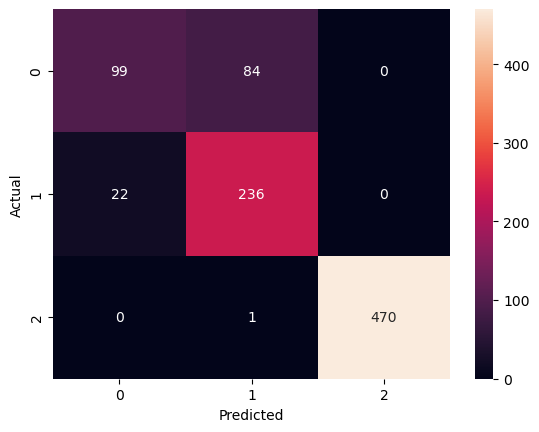

In [7]:
# calculate confusion matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(model.predict(x, verbose=0), axis=1))

confusion_matrix = pd.crosstab(pd.Series(y_true, name="Actual"), pd.Series(y_pred, name="Predicted"))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()

In [8]:
import pickle

with open("models/history.pkl", "rb") as f:
    history = pickle.load(f)

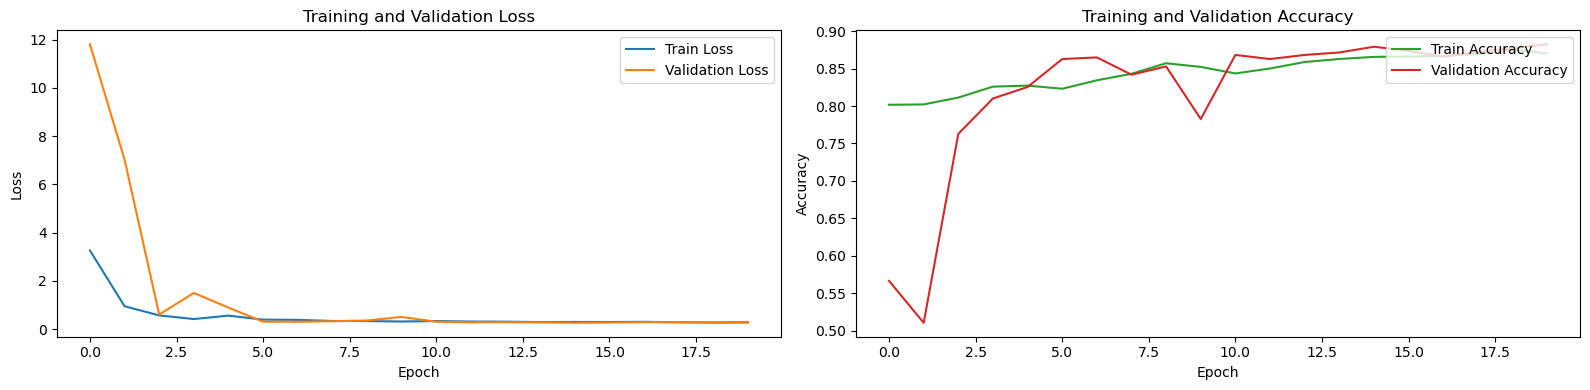

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Plot loss on training and validation sets
ax1.plot(history["loss"], label="Train Loss", color="tab:blue")
ax1.plot(history["val_loss"], label="Validation Loss", color="tab:orange")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.set_title("Training and Validation Loss")

# Plot accuracy on training and validation sets
ax2.plot(history["accuracy"], label="Train Accuracy", color="tab:green")
ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="tab:red")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper right")
ax2.set_title("Training and Validation Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

filepath = "data/raw_data/atopic_dermatitis/0_0.jpg"
input_shape = (256, 256, 3)

image_array, _ = data_loader.load_and_preprocess_image(filepath, None)
predictions = model.predict(np.expand_dims(image_array, axis=0))[0]
class_idx = np.argmax(predictions)

print(f"Predicted class index: {class_idx}")
print(f"Predicted class: {data_loader.get_class_mapping()[class_idx]}")
print(f"Predictions: {predictions}")

<class 'tensorflow.python.framework.ops.EagerTensor'> (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicted class index: 0
Predicted class: atopic_dermatitis
Predictions: [8.2541925e-01 1.7458068e-01 9.6211117e-08]


In [13]:
import numpy as np
import os

class_dir = "data/raw_data/eczema"
label_idx = 1
input_shape = (256, 256, 3)

class_images = []
class_predictions = []

for image_name in os.listdir(class_dir):
    if image_name.lower().endswith(("png", "jpg", "jpeg")):
        filepath = os.path.join(class_dir, image_name)
        image_array, label = data_loader.load_and_preprocess_image(filepath, input_shape)
        class_images.append(image_array)

len(class_images)

1677

In [15]:
probabilities = model.predict(np.array(class_images))
predictions = np.argmax(probabilities, axis=1)

# count how many images were correctly classified
correctly_classified = np.sum(predictions == label_idx)
print(f"Correctly classified: {correctly_classified} out of {len(class_images)}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Correctly classified: 1514 out of 1677
